# Progetto su Time Series
A cura di:
- Marco Michellini 207429
- Matteo Battilori 207260
- Christian von Waldorff 208420

## Introduzione 
Il dataset contiene il valore di CO2 emessa dal vulcano Mauna Loa misurata mensilmente, ed è reperibile al seguente [link](https://datahub.io/core/co2-ppm).

## Obiettivo 
L'obiettivo di questo lavoro è di analizzare la timeseries, renderla stazionaria ed applicare un metodo autoregressivo per predire.

---

<br>

### Importazione delle librerie necessarie per l'analisi 

In [59]:
import os 
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from scipy.stats import boxcox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from scipy.special import inv_boxcox
from statsmodels.tsa.arima.model import ARIMA

In [60]:
df=pd.read_csv('co2_mm_mlo.csv')
df.head()

,year,month,decimal date,average,deseasonalized,ndays,sdev,unc
0,1958,3,1958.2027,315.71,314.44,-1,-9.99,-0.99
1,1958,4,1958.2877,317.45,315.16,-1,-9.99,-0.99
2,1958,5,1958.3699,317.51,314.69,-1,-9.99,-0.99
3,1958,6,1958.4548,317.27,315.15,-1,-9.99,-0.99
4,1958,7,1958.5370,315.87,315.20,-1,-9.99,-0.99


### Pulizia dei dati

Uniamo la colonna `year` e `month` per unirle e creare un'unica colonna `Date` di tipo `dateTime`.  
Eliminiamo le colonne irrilevanti per l'analisi  

Otteniamo un DataFrame nella struttura ideale per proseguire con le analisi successive

In [61]:
df['Date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str) + '-01')
df=df.drop(columns=['decimal date', 'deseasonalized', 'ndays', 'sdev', 'unc', 'year', 'month'])
df.describe()

,average,Date
count,806.000000,806
mean,360.027184,1991-09-16 03:25:27.543424256
min,312.420000,1958-03-01 00:00:00
25%,330.742500,1974-12-08 18:00:00
50%,355.735000,1991-09-16 00:00:00
75%,386.187500,2008-06-23 12:00:00
max,429.640000,2025-04-01 00:00:00
std,32.403905,NaN


In [62]:
df.head(10)

,average,Date
0,315.71,1958-03-01
1,317.45,1958-04-01
2,317.51,1958-05-01
3,317.27,1958-06-01
4,315.87,1958-07-01
5,314.93,1958-08-01
6,313.21,1958-09-01
7,312.42,1958-10-01
8,313.33,1958-11-01
9,314.67,1958-12-01


In [63]:
df.isna().sum()

average    0
Date       0
dtype: int64

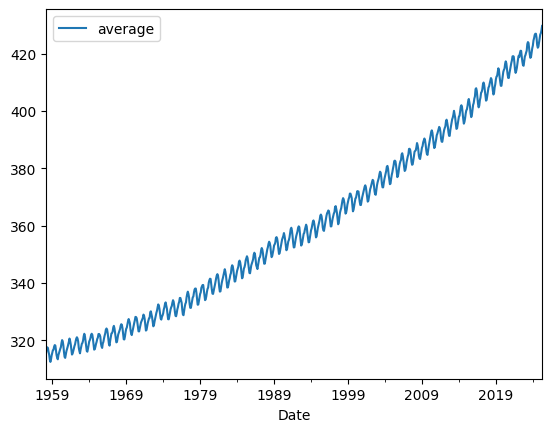

In [64]:
df.plot(x='Date',y='average')
plt.show()

### Visualizzazione del Trend con Media Mobile

Per evidenziare meglio il trend di fondo della serie storica, calcoliamo e visualizziamo una media mobile a 12 mesi (annuale) centrata, sovrapposta alla serie originale. La media mobile smorza le fluttuazioni stagionali e il rumore, rivelando più chiaramente la tendenza crescente dei livelli di CO2.

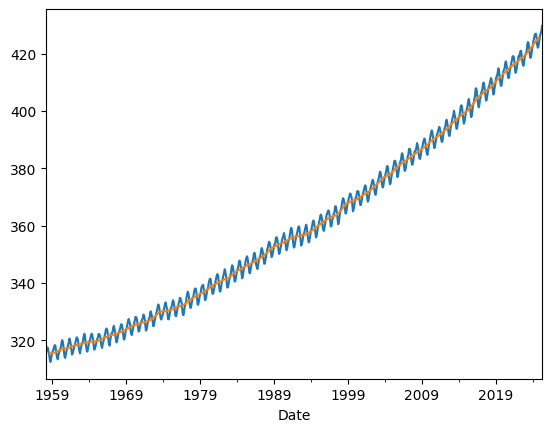

In [65]:
df0=df.copy()
# imposta Date come indice -> DatetimeIndex
df0.set_index('Date',inplace=True)
df0['average'].plot()
df0['average'].rolling(12,center=True).mean().plot()
plt.show()

In [66]:
# Creazione della figura Plotly
fig = go.Figure()

# Aggiunta della traccia della serie temporale
fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['average'],
    mode='lines+markers', # Mostra sia le linee che i marcatori per i punti
    name='CO2 Average (ppm)',
    line=dict(color='royalblue', width=2),
    marker=dict(size=4, color='darkblue')
))

# Aggiunta di una media mobile per visualizzare meglio il trend (opzionale, ma utile)
rolling_window = 12
df['rolling_mean'] = df['average'].rolling(window=rolling_window, center=True).mean()

fig.add_trace(go.Scatter(
    x=df['Date'],
    y=df['rolling_mean'],
    mode='lines',
    name=f'Media Mobile ({rolling_window} periodi)',
    line=dict(color='darkorange', width=2, dash='dash')
))


# Personalizzazione del layout del grafico
fig.update_layout(
    title_text='Analisi Interattiva della Serie CO2 (ppm)',
    title_x=0.5, # Centra il titolo
    xaxis_title='Data',
    yaxis_title='CO2 Average (ppm)',
    xaxis_rangeslider_visible=True, # Aggiunge un range slider per facilitare lo zoom sull'asse x
    hovermode='x unified', # Mostra informazioni per tutti i punti con la stessa x al passaggio del mouse
    template='plotly_white' # Un tema pulito
)

# Mostra il grafico
fig.show()

### Trasformazione Logaritmica per Stabilizzare la Varianza

Per cercare di stabilizzare la varianza della serie, applichiamo una trasformazione logaritmica ai dati. Visualizziamo quindi la serie trasformata (`log_average`) e la sua media mobile a 12 mesi per osservare l'effetto sul trend e sulla variabilità delle fluttuazioni stagionali.

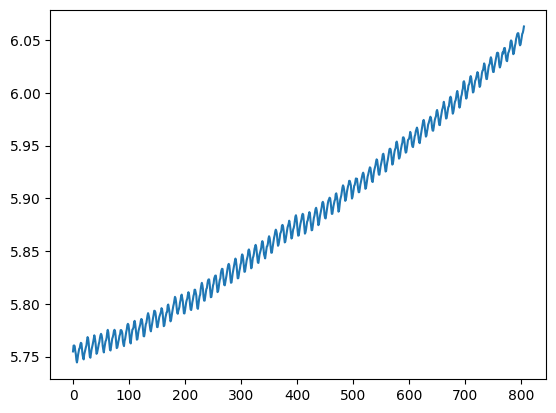

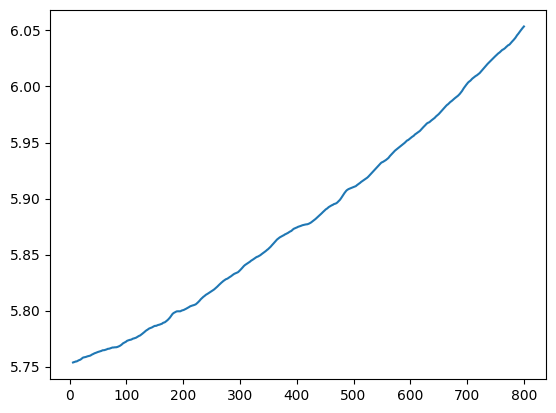

In [67]:
df['log_average']=np.log(df['average'])
df['log_average'].plot()
plt.show()

print("\n")

df['log_average'].rolling(12,center=True).mean().plot()
plt.show()

### Osservazioni sulla Trasformazione Logaritmica

Dopo aver applicato la trasformazione logaritmica, si osserva che la forma generale della serie `log_average` (come visualizzata nel grafico soprastante) e della sua media mobile rimane visivamente molto simile a quella della serie originale. Il trend crescente e il pattern stagionale sono ancora evidenti, con la principale differenza che risiede nella scala dei valori sull'asse Y.

Nonostante questa somiglianza nella forma, l'obiettivo primario della trasformazione logaritmica è la **stabilizzazione della varianza**. Anche se non stravolge l'aspetto generale del grafico, ci si aspetta che l'ampiezza delle fluttuazioni stagionali nella serie `log_average` sia ora più costante rispetto al livello medio della serie, a differenza della serie originale dove poteva aumentare con l'aumentare dei livelli di CO2. Questa proprietà rende la serie trasformata più idonea per i successivi passaggi di differenziazione e modellazione.

---

<br>

### Feature Engineering per Regressione con Componenti Temporali

Per preparare i dati a un'analisi di regressione che possa modellare esplicitamente il trend e la stagionalità osservati nella serie `log_average`, procediamo con la creazione di opportune variabili esplicative (feature engineering).

Vengono generate:
1.  **Variabili Dummy Mensili:** A partire dalla data, si estraggono i mesi e si creano variabili dummy (indicatrici) per ciascun mese (con una categoria di riferimento per evitare multicollinearità). Queste variabili permetteranno al modello di regressione di stimare un effetto specifico per ogni mese, catturando così il pattern stagionale.
2.  **Variabile di Trend Temporale:** Viene costruita una variabile numerica (`time`) che rappresenta il passare del tempo in modo lineare (un contatore di giorni cumulativi dall'inizio della serie). Questa variabile servirà a modellare il trend di lungo periodo osservato nei dati.

In [68]:
df['Date_no']=df['Date'].dt.month
month_vars=pd.get_dummies(df['Date_no'], drop_first=True,prefix='m').astype(int)

df_regr = pd.concat([df,month_vars], axis=1)

df_regr['time']=df_regr['Date'].diff().dt.days.fillna(0).cumsum()

df_regr.head()

,average,Date,rolling_mean,log_average,Date_no,m_2,m_3,m_4,m_5,m_6,m_7,m_8,m_9,m_10,m_11,m_12,time
0,315.71,1958-03-01,NaN,5.754824,3,0,1,0,0,0,0,0,0,0,0,0,0.0
1,317.45,1958-04-01,NaN,5.760320,4,0,0,1,0,0,0,0,0,0,0,0,31.0
2,317.51,1958-05-01,NaN,5.760509,5,0,0,0,1,0,0,0,0,0,0,0,61.0
3,317.27,1958-06-01,NaN,5.759753,6,0,0,0,0,1,0,0,0,0,0,0,92.0
4,315.87,1958-07-01,NaN,5.755331,7,0,0,0,0,0,1,0,0,0,0,0,122.0


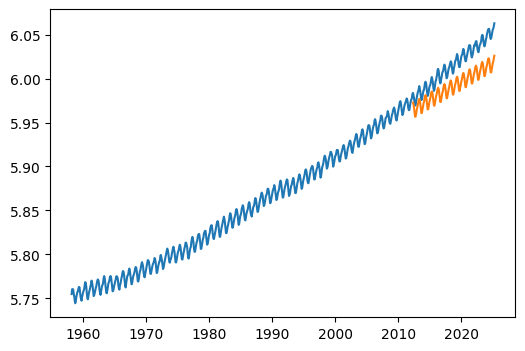

,Odds Ratio,5%,95%,t-value,p-value
const,5.736524,5.734684,5.738363,6123.542230,0.000000e+00
time,0.000012,0.000011,0.000012,272.587629,0.000000e+00
m_2,0.001849,-0.000474,0.004172,1.562732,1.186122e-01
m_3,0.004265,0.001952,0.006577,3.621116,3.166602e-04
m_4,0.007463,0.005150,0.009775,6.336553,4.445182e-10
m_5,0.008478,0.006155,0.010801,7.165638,2.148638e-12
m_6,0.006593,0.004270,0.008916,5.572587,3.707311e-08
m_7,0.002083,-0.000240,0.004407,1.760928,7.873030e-02
m_8,-0.004057,-0.006381,-0.001734,-3.429483,6.437655e-04
m_9,-0.009016,-0.011339,-0.006693,-7.620798,9.174165e-14


In [69]:
# split data into training and test sets 20%
features=['time', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6', 'm_7', 'm_8', 'm_9', 'm_10', 'm_11', 'm_12']
Y_train = df_regr['log_average'].iloc[:-156]
X_train = df_regr[features].iloc[:-156]
X_train = sm.add_constant(X_train)

Y_test = df_regr['log_average'].iloc[-156:]
X_test = df_regr[features].iloc[-156:]
X_test = sm.add_constant(X_test)

# fit regression model
model = sm.OLS(Y_train,X_train)
results = model.fit()



predictions = results.predict(X_test)
# Plot the real data points and the model predictions
plt.figure(figsize=(6, 4))
plt.plot(df['Date'], df['log_average'])
plt.plot(df['Date'].iloc[-156:], predictions)
plt.show()


conf = results.conf_int()
params=np.reshape(results.params,(results.params.size,1))
tvalues=np.reshape(results.tvalues,(results.tvalues.size,1))
pvalues=np.reshape(results.pvalues,(results.pvalues.size,1))
res_df=pd.DataFrame(np.concatenate((params,conf,tvalues,pvalues),axis=1))
res_df.columns=['Odds Ratio','5%', '95%', 't-value','p-value']
res_df.index=['const']+features
res_df

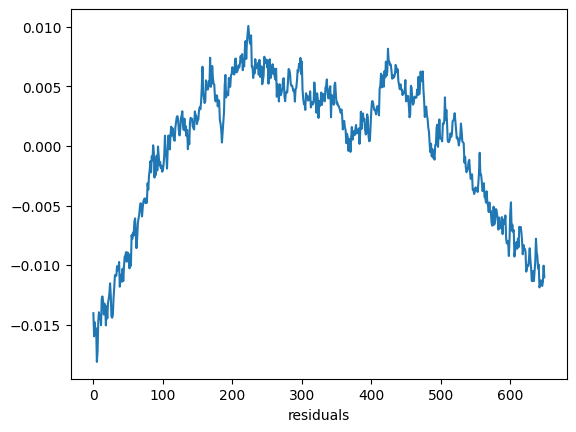

ADF Statistic:  -1.6272845911491145
P-Value:  0.4689123836359126
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57

Residuals are not stationary.


        lb_stat      lb_pvalue
1    630.223268  4.469538e-139
2   1245.232846  3.991381e-271
3   1845.262257   0.000000e+00
4   2431.198323   0.000000e+00
5   3003.618626   0.000000e+00
6   3561.089391   0.000000e+00
7   4104.994198   0.000000e+00
8   4638.984454   0.000000e+00
9   5164.346349   0.000000e+00
10  5678.831919   0.000000e+00

Residuals show non-trivial autocorrelation!


In [70]:
plt.plot((results.predict(X_train) - Y_train))
plt.xlabel('time')
plt.xlabel('residuals')
plt.show()


### TEST STATIONARITY OF RESIDUALS
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    """Using an ADF test to determine if a series is stationary"""
    test_results = adfuller(series)
    print('ADF Statistic: ', test_results[0])
    print('P-Value: ', test_results[1])
    print('Critical Values:')
    for thres, adf_stat in test_results[4].items():
        print('\t%s: %.2f' % (thres, adf_stat))

adf_test((results.predict(X_train) - Y_train))
print('\nResiduals are not stationary.\n\n')

from statsmodels.stats.diagnostic import acorr_ljungbox

print(acorr_ljungbox((results.predict(X_train) - Y_train), return_df=True))
print('\nResiduals show non-trivial autocorrelation!')

### Analisi dei Residui del Modello OLS: Risultati e Osservazioni

L'analisi dei residui del precedente modello di regressione OLS fornisce indicazioni cruciali sulla sua adeguatezza:

1.  **Visualizzazione dei Residui:** Il grafico dei residui non mostra un andamento casuale (rumore bianco), ma presenta ancora dei pattern, suggerendo che componenti della serie non sono state pienamente catturate.

2.  **Test di Stazionarietà (ADF):**
    *   Il test di Dickey-Fuller Aumentato sui residui ha prodotto una statistica ADF di circa -1.63 e un p-value di circa 0.47.
    *   Dato che il p-value è elevato (ben superiore a 0.05) e la statistica ADF è maggiore dei valori critici, si conclude che **i residui non sono stazionari.**

3.  **Test di Autocorrelazione (Ljung-Box):**
    *   Il test di Ljung-Box ha rivelato p-value estremamente bassi (prossimi a zero) per tutti i lag considerati.
    *   Ciò indica la presenza di **autocorrelazione significativa nei residui**, ovvero non sono indipendenti e il loro valore corrente è legato ai valori passati.

**Conclusione:**
Nonostante il modello OLS abbia catturato il trend e la stagionalità deterministica, i suoi residui non sono stazionari e presentano una chiara struttura di autocorrelazione. Questo significa che il modello è incompleto. Per migliorare le previsioni, sarà necessario affrontare queste caratteristiche dei residui rendendoli stazionari.

Text(0.5, 0, '')

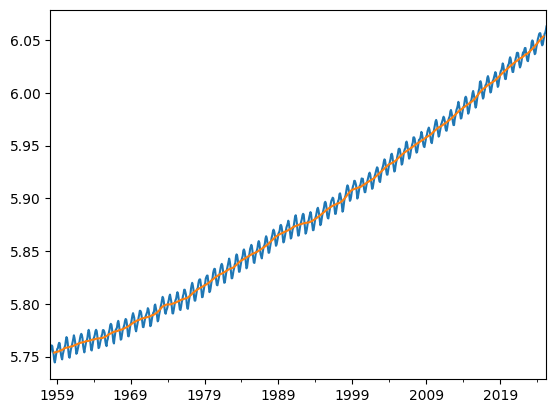

In [71]:
df.set_index('Date',inplace=True)
df['log_average'] = np.log(df['average'])
df['log_average'].plot()
df['log_average'].rolling(12,center=True).mean().dropna().plot()
plt.xlabel('')

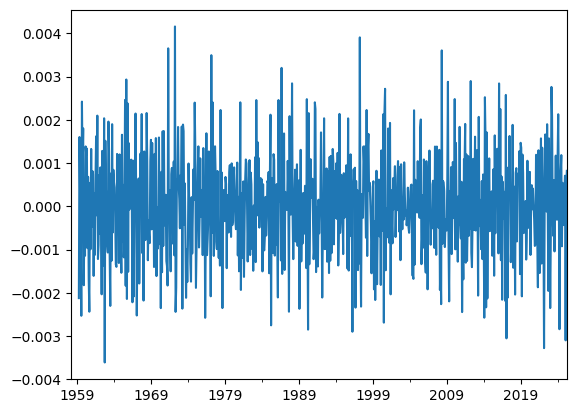

ADF Statistic:  -11.467344259718761
P-Value:  5.370829333870948e-21
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


In [72]:
df['diff_diff12_log_average']=np.log(df['average']).diff(12).diff(1)
df['diff_diff12_log_average'].plot()
plt.xlabel('')
plt.show()

adf_test(df["diff_diff12_log_average"].dropna())

### Trasformazione della Serie per Stazionarietà

Prima di applicare modelli autoregressivi, è necessario che la serie temporale sia stazionaria. La serie `log_average`, pur avendo la varianza stabilizzata, presenta ancora un chiaro trend e stagionalità.

Per affrontare questo, applichiamo una combinazione di differenziazione stagionale e non stagionale:
1.  **Differenziazione Stagionale:** Si calcola la differenza tra un'osservazione e quella di 12 periodi prima (essendo dati mensili, `diff(12)`), sulla serie `log_average`. Questo mira a rimuovere la componente stagionale.
2.  **Differenziazione Non Stagionale:** Al risultato della differenziazione stagionale, si applica una prima differenza (`diff(1)`) per rimuovere il trend.

La serie risultante, `diff_diff12_log_average`, viene quindi visualizzata.

**Verifica della Stazionarietà (Test ADF):**

Per confermare formalmente la stazionarietà della serie trasformata `diff_diff12_log_average`, viene eseguito il test di Dickey-Fuller Aumentato (ADF).
*   **Statistica ADF:** -11.47
*   **P-Value:** 5.37e-21

**Risultati e Osservazioni:**
Il grafico della serie `diff_diff12_log_average` mostra un andamento che fluttua attorno a zero, senza un trend o una stagionalità evidenti, suggerendo visivamente la stazionarietà.

Il test ADF rinforza questa osservazione: la statistica ADF è significativamente più negativa dei valori critici e il p-value è estremamente piccolo (ben inferiore a 0.05). Pertanto, **rifiutiamo l'ipotesi nulla e concludiamo che la serie `diff_diff12_log_average` è stazionaria.**

Questo risultato è fondamentale, poiché ora disponiamo di una serie stazionaria sulla quale è possibile identificare e adattare un modello della famiglia ARIMA/SARIMA per catturare le dipendenze temporali residue.

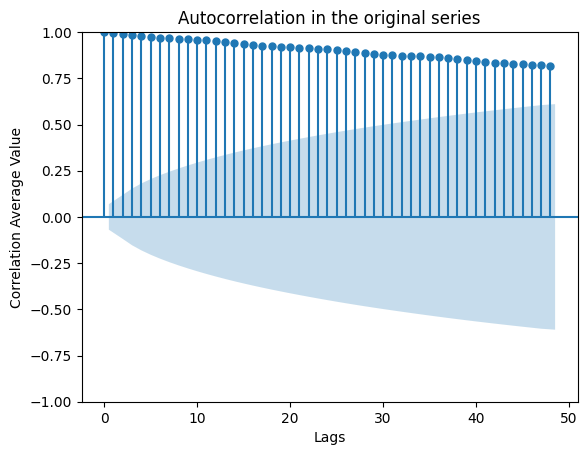

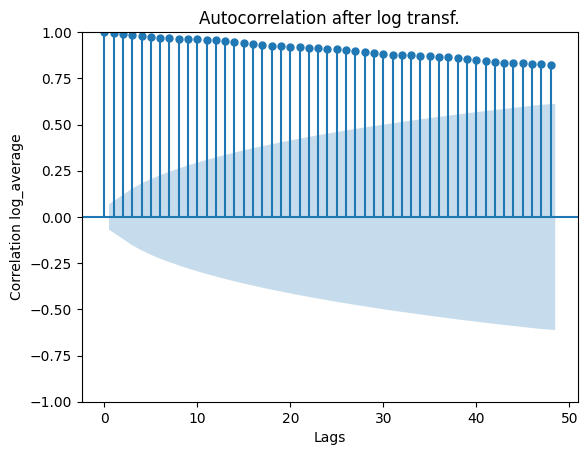

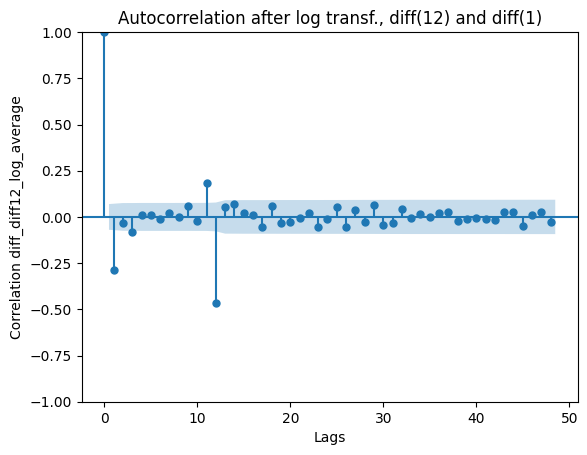

      lb_stat     lb_pvalue
1   65.259704  6.565011e-16
2   66.052627  4.537894e-15
3   71.303509  2.244414e-15
4   71.381736  1.159340e-14
5   71.467201  5.071928e-14
6   71.567921  1.949087e-13
7   71.944754  5.971906e-13
8   71.946703  2.011205e-12
9   74.779462  1.746932e-12
10  75.090090  4.569510e-12



In [73]:
plot_acf(df['average'],lags=48)
plt.ylabel('Correlation Average Value')
plt.xlabel('Lags')
plt.title('Autocorrelation in the original series')
plt.show()

plot_acf(df['log_average'].dropna(),lags=48)
plt.ylabel('Correlation log_average')
plt.xlabel('Lags')
plt.title('Autocorrelation after log transf.')
plt.show()

plot_acf(df['diff_diff12_log_average'].dropna(),lags=48)
plt.ylabel('Correlation diff_diff12_log_average')
plt.xlabel('Lags')
plt.title('Autocorrelation after log transf., diff(12) and diff(1)')
plt.show()

# Carry out Ljung-Box test to check autocorrelation leftovers
print(acorr_ljungbox(df['diff_diff12_log_average'].dropna(), return_df=True))
print()

### Analisi dell'Autocorrelazione (ACF)

Dopo aver trasformato la serie `log_average` per ottenere stazionarietà (`diff_diff12_log_average`), analizziamo la struttura di autocorrelazione utilizzando i grafici della Funzione di Autocorrelazione (ACF) e il test di Ljung-Box.

**Osservazioni dai Grafici ACF:**

1.  **Serie Originale (`average`) e Log-Trasformata (`log_average`):** Entrambi i grafici ACF mostrano un decadimento molto lento delle autocorrelazioni, tipico di serie non stazionarie con trend e stagionalità. Le correlazioni rimangono elevate e positive per numerosi lag.

2.  **Serie Stazionaria (`diff_diff12_log_average`):**
    *   L'ACF di questa serie è marcatamente differente: le autocorrelazioni decadono rapidamente verso zero.
    *   Si nota una **significativa autocorrelazione negativa al lag 1**.
    *   È visibile una **autocorrelazione positiva potenzialmente significativa intorno al lag 12**.

**Risultati del Test di Ljung-Box sulla serie `diff_diff12_log_average`:**

Il test di Ljung-Box, applicato alla serie stazionaria `diff_diff12_log_average`, produce p-value estremamente bassi (es. per lag 1, p-value ≈ 6.57e-16) per tutti i primi 10 lag. Questo porta a **rifiutare l'ipotesi nulla di assenza di autocorrelazione.**

**Conclusione:**
L'analisi ACF e il test di Ljung-Box confermano che, sebbene la serie `diff_diff12_log_average` sia stazionaria (come stabilito dal test ADF), essa conserva una struttura di autocorrelazione significativa.  
Questo significa che c'è ancora una struttura di dipendenza temporale che i componenti AR (Autoregressivi) e/o MA (Media Mobile) di un modello ARIMA possono catturare e modellare.  


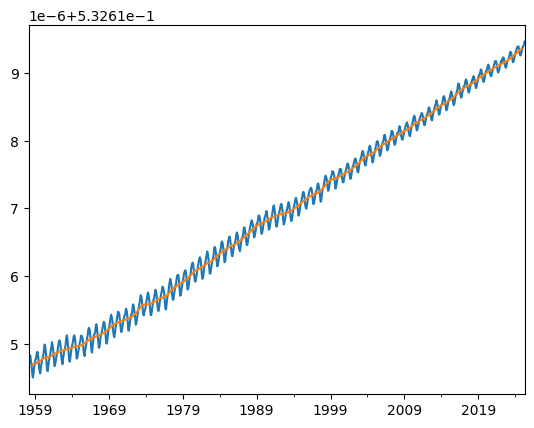

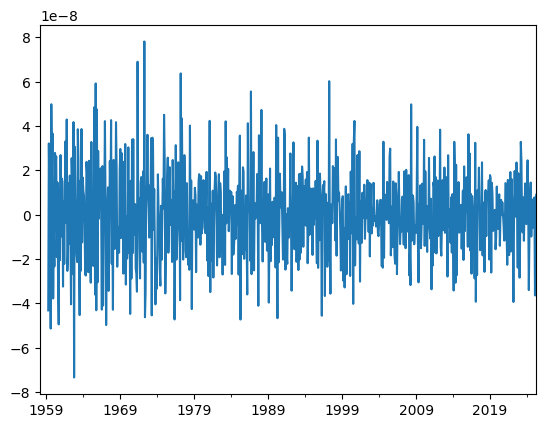

ADF Statistic:  -11.532049979474865
P-Value:  3.810953443629549e-21
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


In [74]:
transformed, lambda0 = boxcox(df['average'])
df['BoxCox_average']= transformed

df['BoxCox_average'].plot()
df['BoxCox_average'].rolling(12,center=True).mean().dropna().plot()
plt.xlabel('')
plt.show()


## remove seasonality and trend
df['diff_diff12_BoxCox_average']=df['BoxCox_average'].diff(12).diff(1)
df['diff_diff12_BoxCox_average'].plot()
plt.xlabel('')
plt.show()


#test stationarity
adf_test(df["diff_diff12_BoxCox_average"].dropna())

### Esplorazione Alternativa: Trasformazione di Box-Cox per la Stazionarietà

Come approccio alternativo alla trasformazione logaritmica per stabilizzare la varianza e preparare la serie alla stazionarietà, viene qui esplorata la **trasformazione di Box-Cox**.

1.  **Applicazione della Trasformazione di Box-Cox:** La trasformazione di Box-Cox viene applicata alla serie originale `average`. La serie trasformata (`BoxCox_average`) e la sua media mobile sono visualizzate per un'ispezione preliminare.

2.  **Differenziazione per Rimuovere Trend e Stagionalità:** Similmente a quanto fatto con la serie log-trasformata, alla serie `BoxCox_average` viene applicata una differenziazione stagionale (lag 12) seguita da una differenziazione non stagionale (lag 1). La serie risultante, `diff_diff12_BoxCox_average`, viene plottata.

**Verifica della Stazionarietà (Test ADF) sulla serie Box-Cox Trasformata e Differenziata:**

Il test di Dickey-Fuller Aumentato (ADF) sulla serie `diff_diff12_BoxCox_average` produce i seguenti risultati:
*   **Statistica ADF:** circa -11.53
*   **P-Value:** circa 3.81e-21

**Risultati e Osservazioni:**
Il grafico della serie `diff_diff12_BoxCox_average` mostra un andamento fluttuante attorno a zero, suggerendo visivamente la stazionarietà. Il test ADF conferma questa osservazione: la statistica ADF è nettamente più negativa dei valori critici e il p-value è estremamente piccolo. Si conclude quindi che anche la **serie trasformata con Box-Cox e successivamente differenziata è stazionaria.**

In [75]:
print(f"Tipo di df0.index: {type(df0.index)}")
print(f"Frequenza dell'indice: {df0.index.freq}")
print(df0.head()) # Per vedere come appare l'indice

Tipo di df0.index: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
Frequenza dell'indice: None
            average
Date               
1958-03-01   315.71
1958-04-01   317.45
1958-05-01   317.51
1958-06-01   317.27
1958-07-01   315.87


---

<br>


### Analisi Comparativa della Decomposizione Stagionale su Diverse Trasformazioni della Serie

Per comprendere meglio la struttura della serie e identificare l'approccio di decomposizione più adeguato, sono state eseguite analisi di decomposizione stagionale su tre versioni della serie originale (`average`):
1.  Sulla serie **`average` originale**, utilizzando un modello **additivo**.
2.  Sulla serie trasformata **`log_average`**, utilizzando un modello **additivo** (coerente con l'idea che la trasformazione logaritmica renda additiva una potenziale relazione moltiplicativa originale).
3.  Sulla serie trasformata **`BoxCox_average`**, utilizzando un modello **additivo** (la trasformazione Box-Cox mira a stabilizzare la varianza e normalizzare, rendendo un modello additivo sulla scala trasformata più appropriato).

Per ciascuna decomposizione, sono state analizzate le componenti (trend, stagionalità, residui) e sono stati condotti test di stazionarietà (ADF) e di autocorrelazione (Ljung-Box) sui residui.

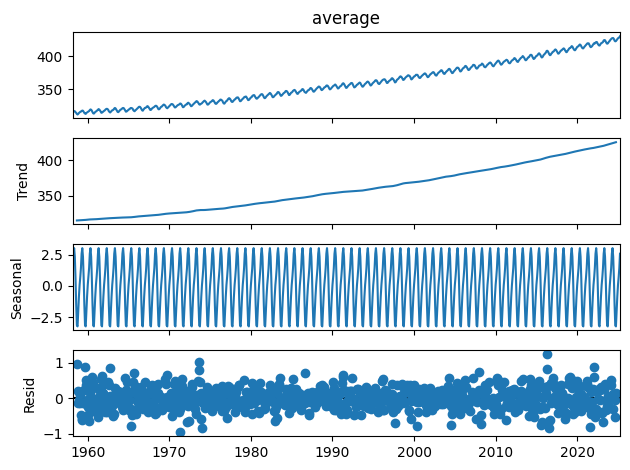

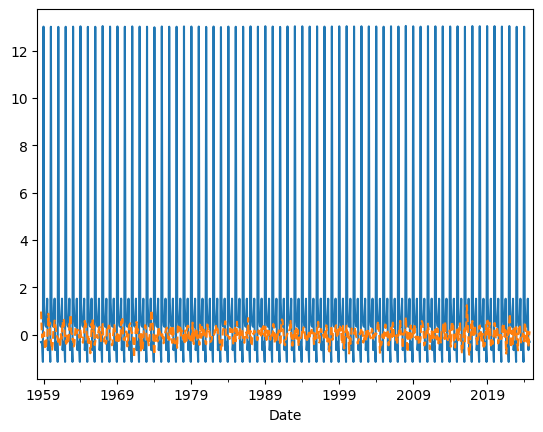

ADF Statistic:  -10.310791814288386
P-Value:  3.189466971266973e-18
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


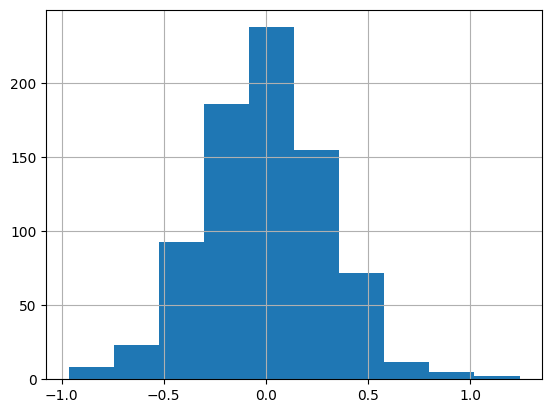

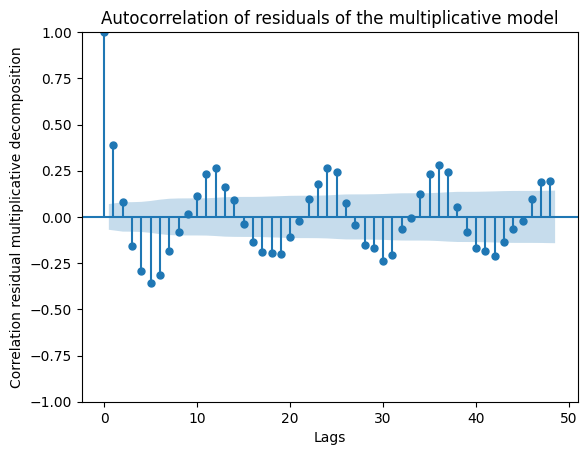


       lb_stat     lb_pvalue
1   122.166314  2.122762e-28
2   127.721296  1.843626e-28
3   148.160384  6.570367e-32
4   216.797813  9.161490e-46
5   319.558698  6.229108e-67
6   398.798910  5.066299e-83
7   426.646449  4.581580e-88
8   432.191650  2.413274e-88
9   432.392303  1.661817e-87
10  442.572783  8.017418e-89


In [76]:
df0=df.copy()
decomposition_plot_multi = seasonal_decompose(df0['average'],model='additive')

# plot the various components
decomposition_plot_multi.plot()
plt.show()

#trend: decomposition_plot_multi.trend
#season: decomposition_plot_multi.seasonal
#residuals: decomposition_plot_multi.resid
## check that the model can be reconstructed using the decomposed attributes
(df0['average'] / (decomposition_plot_multi.trend * decomposition_plot_multi.seasonal)).dropna().plot(linestyle='-')
decomposition_plot_multi.resid.plot(linestyle='--')

plt.show()

adf_test(decomposition_plot_multi.resid.dropna())

decomposition_plot_multi.resid.hist(bins=10)
plt.show()


plot_acf(decomposition_plot_multi.resid.dropna(),lags=48)
plt.ylabel('Correlation residual multiplicative decomposition')
plt.xlabel('Lags')
plt.title('Autocorrelation of residuals of the multiplicative model')
plt.show()
print()

# Carry out Ljung-Box test
print(acorr_ljungbox(decomposition_plot_multi.resid.dropna(), return_df=True))

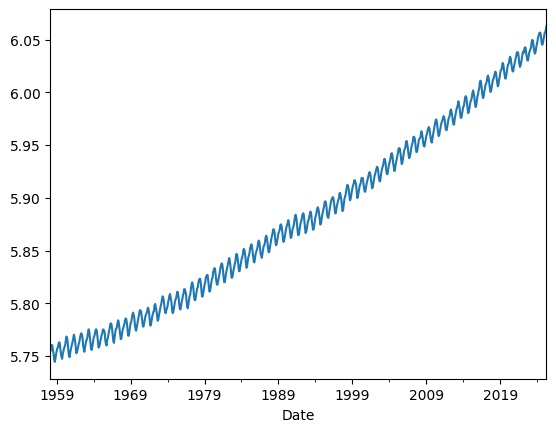

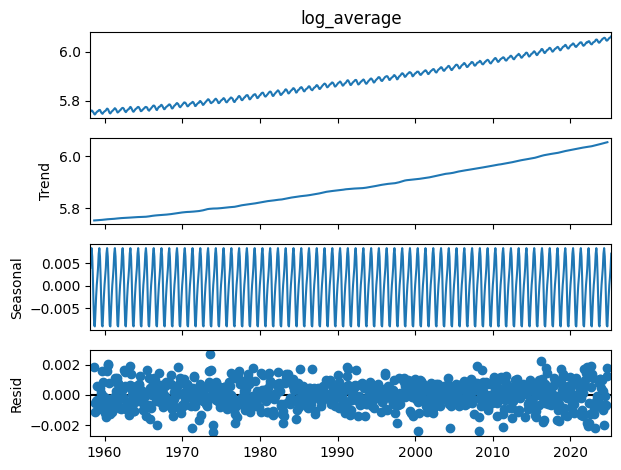

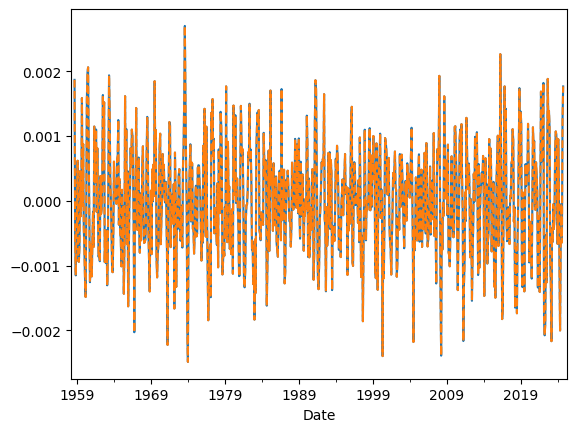

ADF Statistic:  -10.210214409970733
P-Value:  5.664168857193484e-18
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


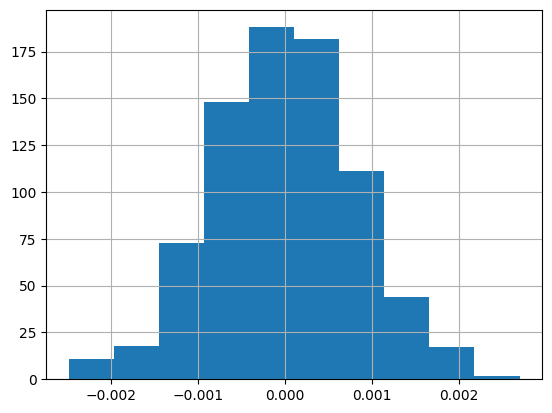

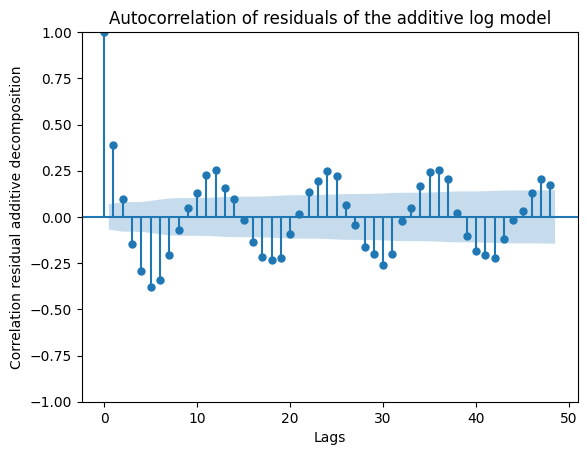


       lb_stat     lb_pvalue
1   122.170679  2.118097e-28
2   130.066589  5.706884e-29
3   146.737906  1.331711e-31
4   216.462307  1.081817e-45
5   330.729014  2.460752e-69
6   425.560842  8.903335e-89
7   458.892901  5.464330e-95
8   462.999342  6.054945e-95
9   465.004253  1.774263e-94
10  478.321589  1.886380e-96


In [77]:
df0['log_average'].plot()
plt.show()

# decompose
decomposition_plot_addi = seasonal_decompose(df0['log_average'],model='additive')
decomposition_plot_addi.plot()
plt.show()


# check decomposition consistency
(df0['log_average'] - decomposition_plot_addi.trend - decomposition_plot_addi.seasonal).dropna().plot(linestyle='-')
decomposition_plot_addi.resid.plot(linestyle='--')
plt.show()

# test residuals stationarity
adf_test(decomposition_plot_addi.resid.dropna())

decomposition_plot_addi.resid.hist(bins=10)
plt.show()


plot_acf(decomposition_plot_addi.resid.dropna(),lags=48)
plt.ylabel('Correlation residual additive decomposition')
plt.xlabel('Lags')
plt.title('Autocorrelation of residuals of the additive log model')
plt.show()
print()
# Carry out Ljung-Box test
print(acorr_ljungbox(decomposition_plot_addi.resid.dropna(), return_df=True))

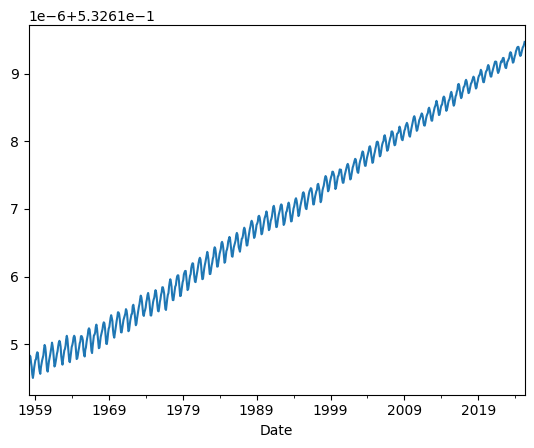

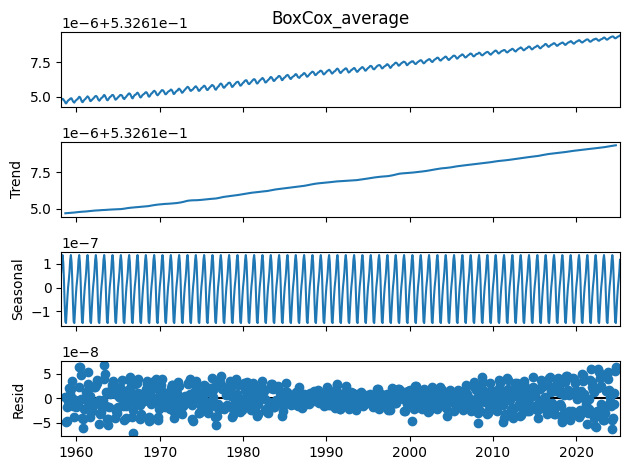

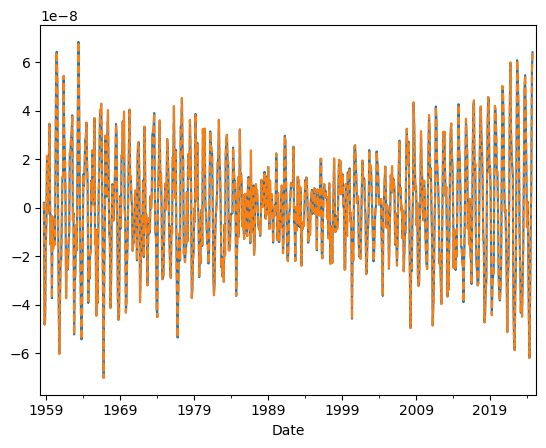

ADF Statistic:  -11.177131043921941
P-Value:  2.5542633234083745e-20
Critical Values:
	1%: -3.44
	5%: -2.87
	10%: -2.57


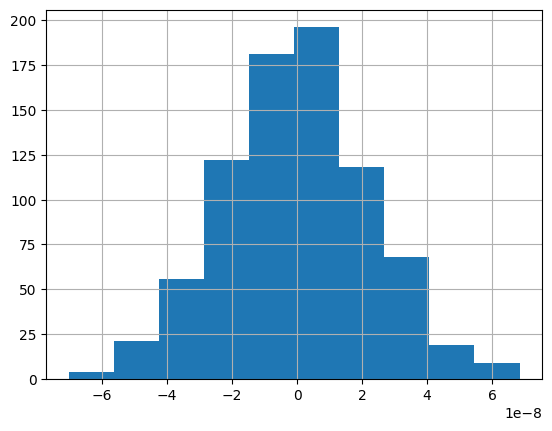

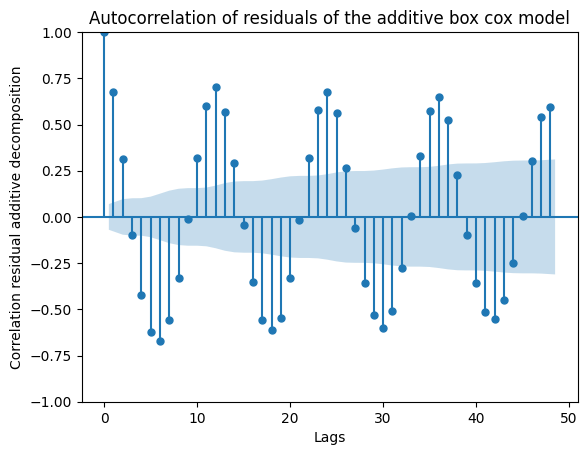


        lb_stat      lb_pvalue
1    364.580299   2.833050e-81
2    442.307488   8.998069e-97
3    449.592952   3.994326e-97
4    593.886169  3.261296e-127
5    906.816249  8.910196e-194
6   1267.773685  1.025194e-270
7   1519.655438   0.000000e+00
8   1608.885381   0.000000e+00
9   1608.967258   0.000000e+00
10  1691.245594   0.000000e+00


In [78]:
df0['BoxCox_average'].plot()
plt.show()

# decompose
decomposition_plot_addi = seasonal_decompose(df0['BoxCox_average'],model='additive')
decomposition_plot_addi.plot()
plt.show()


# check decomposition consistency
(df0['BoxCox_average'] - decomposition_plot_addi.trend - decomposition_plot_addi.seasonal).dropna().plot(linestyle='-')
decomposition_plot_addi.resid.plot(linestyle='--')
plt.show()

# test residuals stationarity
adf_test(decomposition_plot_addi.resid.dropna())

decomposition_plot_addi.resid.hist(bins=10)
plt.show()


plot_acf(decomposition_plot_addi.resid.dropna(),lags=48)
plt.ylabel('Correlation residual additive decomposition')
plt.xlabel('Lags')
plt.title('Autocorrelation of residuals of the additive box cox model')
plt.show()
print()
# Carry out Ljung-Box test
print(acorr_ljungbox(decomposition_plot_addi.resid.dropna(), return_df=True))

**Risultati e Osservazioni Comuni tra le Tre Decomposizioni:**

*   **Stazionarietà dei Residui:** In tutti e tre gli approcci, il test ADF sui rispettivi residui ha prodotto statistiche ADF fortemente negative e p-value estremamente bassi (es. per `log_average` ADF Stat: -11.18, P-Value: ~2.55e-20; per `BoxCox_average` ADF Stat: -11.18, P-Value: ~2.55e-20; simili per `average` additiva). Questo indica che, dopo la decomposizione, i **residui sono risultati stazionari** in tutti i casi.
*   **Autocorrelazione dei Residui:** Similmente, il test di Ljung-Box ha rivelato p-value molto bassi per tutti i lag significativi in tutti e tre i set di residui. Ciò conferma la presenza di **autocorrelazione significativa residua** dopo la decomposizione, suggerendo che c'è ancora una struttura di dipendenza temporale che può essere modellata (ad esempio, con un modello ARIMA).

**Differenze Chiave Osservate e Implicazioni:**

*   **Scala e Aspetto Visivo dei Residui:**
    *   **`average` (modello additivo):** I residui fluttuano attorno a zero sulla scala originale dei ppm. Il grafico che sovrappone la serie originale e i residui evidenzia la piccola magnitudine relativa dei residui rispetto al trend dominante. La componente stagionale estratta dovrebbe essere ispezionata per la stabilità della sua ampiezza nel tempo (attorno a zero).
    *   **`log_average` (modello additivo):** I residui fluttuano attorno a zero sulla scala logaritmica. Il grafico della decomposizione mostra componenti su questa scala. La varianza della componente stagionale (sulla scala log) appare visivamente stabile.
    *   **`BoxCox_average` (modello additivo):** I residui fluttuano attorno a zero sulla scala trasformata da Box-Cox. Similmente alla trasformazione logaritmica, ci si aspetta una maggiore stabilizzazione della varianza della componente stagionale su questa scala.

*   **Valori del Test di Ljung-Box:** Sebbene la conclusione generale di autocorrelazione significativa sia la stessa, i valori specifici di `lb_stat` (e, di conseguenza, i p-value, sebbene tutti estremamente piccoli) differiscono tra le tre serie di residui. Ad esempio, i `lb_stat` per i residui della trasformazione Box-Cox sono risultati notevolmente più alti rispetto a quelli della trasformazione logaritmica o della serie originale additiva. Questo suggerisce che la **natura o l'intensità dell'autocorrelazione residua potrebbe variare leggermente** a seconda della trasformazione iniziale e del modello di decomposizione, il che potrebbe influenzare la scelta degli ordini del successivo modello ARIMA.

**Considerazioni sulla Scelta dell'Approccio:**

Sebbene tutti e tre gli approcci portino a residui stazionari e autocorrelati (pronti per la modellazione ARIMA), la scelta tra di essi può dipendere da:
1.  **Interpretazione e Coerenza con la Natura della Serie:** Se l'ispezione visiva della serie originale (`average`) supporta fortemente un comportamento additivo della stagionalità (ampiezze costanti), la decomposizione additiva sulla serie originale potrebbe essere la più diretta e interpretabile.
2.  **Stabilità della Varianza Stagionale:** Se la trasformazione logaritmica o Box-Cox produce una componente stagionale visibilmente più stabile (in termini di ampiezza costante nel tempo sulla scala trasformata) rispetto alla decomposizione additiva della serie originale, allora lavorare sulla scala trasformata potrebbe essere preferibile.
3.  **Comportamento dei Residui:** Si dovrebbe preferire l'approccio i cui residui (dopo la decomposizione) appaiono più vicini al rumore bianco (a parte l'autocorrelazione che si intende modellare), con la varianza più costante e assenza di pattern residui non desiderati. L'istogramma dei residui può anche dare indicazioni sulla loro distribuzione.
4.  **Performance del Modello Finale:** In ultima analisi, la scelta potrebbe essere guidata dalla performance del modello ARIMA/SARIMA finale costruito sui residui di ciascun approccio, valutata su un set di test.

L'esplorazione di queste diverse pipeline di pre-elaborazione è una parte fondamentale dell'analisi delle serie temporali. I grafici dei componenti della decomposizione (in particolare "Seasonal" e "Resid") e dei loro residui (ACF, istogramma) per ciascuno dei tre metodi sono cruciali per prendere una decisione informata su quale serie di residui utilizzare per la successiva fase di modellazione autoregressiva.

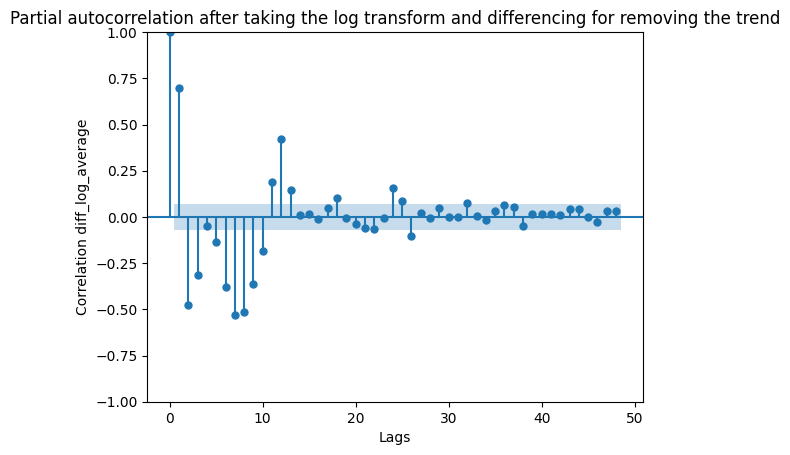

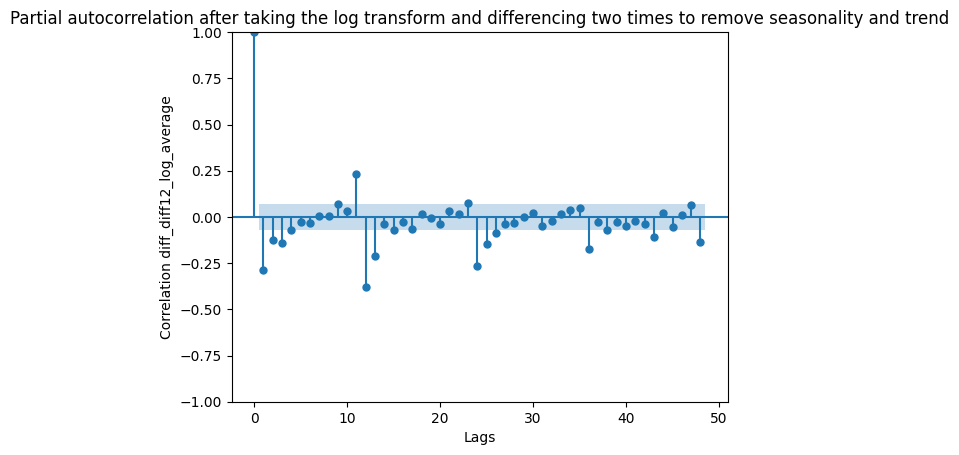

In [79]:
plot_pacf(np.log(df['average']).diff().dropna(),lags=48)
plt.ylabel('Correlation diff_log_average')
plt.xlabel('Lags')
plt.title('Partial autocorrelation after taking the log transform and differencing for removing the trend')



plot_pacf(df['diff_diff12_log_average'].dropna(),lags=48)
plt.ylabel('Correlation diff_diff12_log_average')
plt.xlabel('Lags')
plt.title('Partial autocorrelation after taking the log transform and differencing two times to remove seasonality and trend')
plt.show()


### Analisi dell'Autocorrelazione Parziale (PACF) per l'Identificazione del Modello

Per aiutare nell'identificazione dell'ordine di potenziali termini autoregressivi (AR) per la modellazione, viene analizzata la Funzione di Autocorrelazione Parziale (PACF). La PACF è stata calcolata per due versioni della serie trasformata:

1.  **Serie Log-Trasformata con una Differenza Non Stagionale:**
    *   La PACF è stata plottata per `np.log(df['average']).diff()`. Questa serie è stata resa stazionaria in media per rimuovere il trend, ma conserva ancora la componente stagionale.
    *   **Osservazioni dal grafico PACF:** Si osservano tipicamente uno o più coefficienti di autocorrelazione parziale significativi ai primi lag, che suggeriscono la presenza di dipendenza autoregressiva non stagionale. La persistenza di significatività a lag stagionali (es. 12, 24) è attesa, data la non rimozione della stagionalità.

2.  **Serie Log-Trasformata con Differenziazione Stagionale e Non Stagionale (`diff_diff12_log_average`):**
    *   La PACF è stata plottata per la serie `diff_diff12_log_average`, che è stata precedentemente identificata come stazionaria e con la stagionalità annuale e il trend rimossi.
    *   **Osservazioni dal grafico PACF:**
        *   **Lag Non Stagionali:** Si notano uno o più coefficienti significativi ai primissimi lag (ad esempio, lag 1, e potenzialmente lag successivi di poco), prima che la PACF "tagli" o decada rapidamente. Questo indica l'ordine potenziale *p* per i termini AR non stagionali.
        *   **Lag Stagionali:** Si può osservare una significatività ai lag stagionali (ad esempio, lag 12). Un taglio dopo il primo lag stagionale significativo suggerirebbe un termine AR stagionale di ordine P=1.

**Implicazioni per la Modellazione:**
I pattern osservati nei grafici PACF, in particolare quello della serie completamente stazionariizzata (`diff_diff12_log_average`), forniscono indicazioni cruciali per selezionare il numero di termini autoregressivi da includere in un modello di tipo ARIMA/SARIMA. Se si opta per un modello puramente autoregressivo (come `AutoReg`), l'attenzione si concentra sui lag significativi mostrati dalla PACF della serie stazionaria. Questi grafici supportano la fase successiva di selezione automatica dell'ordine (come con `ar_select_order`) o la specificazione manuale dei lag per il modello autoregressivo che verrà applicato alla serie opportunamente trasformata e differenziata.

---

<br>

### Modellazione Autoregressiva (AutoReg) e Previsione

Dopo aver identificato un'adeguata pipeline di trasformazione e differenziazione per ottenere una serie stazionaria (utilizzando la trasformazione Box-Cox seguita da differenziazione stagionale e poi non stagionale), si procede con l'applicazione di un modello autoregressivo (`AutoReg`) per la previsione.

In [80]:
df.index = pd.to_datetime(df.index)
# Set the frequency explicitly to monthly start ('MS')
df = df.asfreq('MS')

# Apply appropriate differencing for multiplicative data
# First seasonal differencing to remove seasonality, then regular differencing for trend
df['diff_seasonal'] = df['BoxCox_average'].diff(12)
df['diff_seasonal_regular'] = df['diff_seasonal'].diff()

# Split into train and test sets
train = df.iloc[:-156]
test = df.iloc[-156:]

# Find best AR order using the properly differenced series
selector = ar_select_order(train['diff_seasonal_regular'].dropna(), maxlag=12)
print(f"Selected AR lags: {selector.ar_lags}")

# Build AR model with consistent differencing approach
model = AutoReg(
    train['diff_seasonal_regular'].dropna(),
    lags=selector.ar_lags
).fit()

# Get forecasts in the differenced domain
diff_forecasts = list(model.forecast(steps=len(test)))

# Convert forecasts back to original domain
# First, undo the regular differencing
seasonal_diff_forecasts = []
last_seasonal_diff = train['diff_seasonal'].iloc[-1]
for i, diff_forecast in enumerate(diff_forecasts):
    if i == 0:
        seasonal_forecast = diff_forecast + last_seasonal_diff
    else:
        seasonal_forecast = diff_forecast + seasonal_diff_forecasts[i-1]
    seasonal_diff_forecasts.append(seasonal_forecast)

# Then, undo the seasonal differencing
boxcox_forecasts = []
for i, seasonal_diff_forecast in enumerate(seasonal_diff_forecasts):
    if i < 12:  # Use actual values from train for the first 12 months
        idx = len(train) - 12 + i
        boxcox_forecast = seasonal_diff_forecast + train['BoxCox_average'].iloc[idx]
    else:  # Use forecasted values for subsequent months
        boxcox_forecast = seasonal_diff_forecast + boxcox_forecasts[i-12]
    boxcox_forecasts.append(boxcox_forecast)

# Finally, invert the Box-Cox transformation
forecasts = inv_boxcox(boxcox_forecasts, lambda0)

# Plot the forecasts
def plot_forecasts(forecasts, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['average'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['average'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Average Value')
    return fig.show()

plot_forecasts(forecasts, 'Autoregression Forecast')

mean_abs_err=(np.abs(forecasts-test['average'])/test['average']).mean()
print(f'Mean absolute error: {mean_abs_err}')

Selected AR lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Mean absolute error: 0.0013289321426728502


**Risultati delle Previsioni:**

*   **Confronto Visivo:** Il grafico "Autoregression Forecast" mostra una notevole corrispondenza tra i valori reali del test set (linea "Test") e le previsioni generate dal modello (linea "Forecast"). Il modello sembra catturare efficacemente sia il trend di fondo che il pattern stagionale della serie originale.
*   **Accuratezza Quantitativa:** Il Mean Absolute Error (calcolato come errore relativo medio) tra le previsioni e i valori reali del test set è risultato essere circa **0.0013 (o 0.13%)**. Questo valore estremamente basso indica un'elevata accuratezza del modello nel prevedere i livelli di CO2.

**Conclusioni:**
L'approccio che combina la trasformazione di Box-Cox, la doppia differenziazione (stagionale e non stagionale) e un modello `AutoReg` con selezione automatica dell'ordine si è dimostrato molto efficace nel modellare e prevedere la serie storica della CO2. L'elevata accuratezza delle previsioni sul test set convalida la robustezza della pipeline di pre-elaborazione e della scelta del modello autoregressivo.

---

<br>

### Esplorazione di un Modello AutoReg Alternativo con Gestione Interna della Stagionalità (v2)

Come ulteriore esplorazione, è stato testato un approccio alternativo per la modellazione autoregressiva, dove la stagionalità viene gestita parzialmente dal modello `AutoReg` stesso, invece di essere completamente rimossa tramite differenziazione prima dell'addestramento.

In [81]:
# Find best AR order using the twice-differenced series
selector = ar_select_order(train['diff_seasonal_regular'].dropna(), maxlag=12)
print(f"Selected AR lags: {selector.ar_lags}")

# Build AR model on seasonally differenced data with seasonal dummies
model = AutoReg(
    train['diff_seasonal'].dropna(),
    lags=selector.ar_lags,
    seasonal=True,  # Use seasonal dummies
    period=12       # Monthly data
).fit()

# Generate forecasts
diff_forecasts = model.forecast(steps=len(test))

# Undo the seasonal differencing directly (simpler than before)
boxcox_forecasts = []
for i, diff_forecast in enumerate(diff_forecasts):
    if i < 12:  # Use actual values for first 12 steps
        idx = len(train) - 12 + i
        boxcox_forecast = diff_forecast + train['BoxCox_average'].iloc[idx]
    else:  # Use forecasted values for subsequent steps
        boxcox_forecast = diff_forecast + boxcox_forecasts[i-12]
    boxcox_forecasts.append(boxcox_forecast)

# Finally, invert the Box-Cox transformation
forecasts = inv_boxcox(boxcox_forecasts, lambda0)


# Plot the forecasts
def plot_forecasts(forecasts, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['average'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['average'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Average Value')
    return fig.show()

plot_forecasts(forecasts, 'Autoregression Forecast v2')

mean_abs_err=(np.abs(forecasts-test['average'])/test['average']).mean()
print(f'Mean absolute error: {mean_abs_err}')

Selected AR lags: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]


Mean absolute error: 0.004636676238521529


**Risultati delle Previsioni del Modello v2:**

*   **Confronto Visivo:** Il grafico "Autoregression Forecast v2" mostra che le previsioni seguono ancora l'andamento generale dei dati di test, ma un confronto più attento rivela una minore precisione rispetto al modello precedente.
*   **Accuratezza Quantitativa:** Il Mean Absolute Error (calcolato come errore relativo medio) per questo modello è risultato essere circa **0.0046 (o 0.46%)**.

**Conclusioni e Confronto con il Modello v1:**

Questo secondo approccio di modellazione autoregressiva, che tenta di gestire la stagionalità tramite dummy interne al modello `AutoReg` su una serie solo parzialmente differenziata, ha prodotto un errore di previsione più alto (0.46%) rispetto al primo modello (0.13%) che operava su una serie completamente stazionariizzata.

Questo suggerisce che, per questo specifico dataset e problema:
*   Rimuovere esplicitamente sia il trend che la stagionalità tramite differenziazione prima di applicare un modello `AutoReg` puro sulla serie risultante (come fatto nel modello v1) è una strategia più efficace.
*   Affidarsi alle dummy stagionali interne di `AutoReg` su una serie che contiene ancora un trend (anche se la stagionalità principale è stata differenziata) potrebbe portare a una minore capacità del modello di  prevedere accuratamente le diverse componenti.

L'esperimento evidenzia l'importanza della fase di stazionarizzazione della serie prima della modellazione AR e come diverse strategie di gestione della stagionalità e del trend possono impattare la performance predittiva. Il primo approccio di `AutoReg` (v1) si conferma come il modello superiore in termini di accuratezza per questa analisi.

---

<br>

### Identificazione degli Ordini del Modello ARIMA tramite ACF e PACF

Per determinare gli ordini appropriati per un modello ARIMA/SARIMA, vengono analizzate la Funzione di Autocorrelazione (ACF) e la Funzione di Autocorrelazione Parziale (PACF) della serie resa stazionaria. La serie utilizzata per questa analisi è `train['diff_seasonal_regular']`, ottenuta applicando la trasformazione Box-Cox alla serie originale `average`, seguita da una differenziazione stagionale (lag 12) e una differenziazione non stagionale (lag 1).

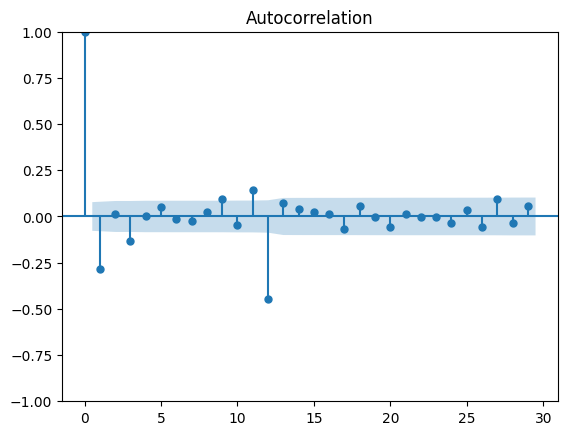

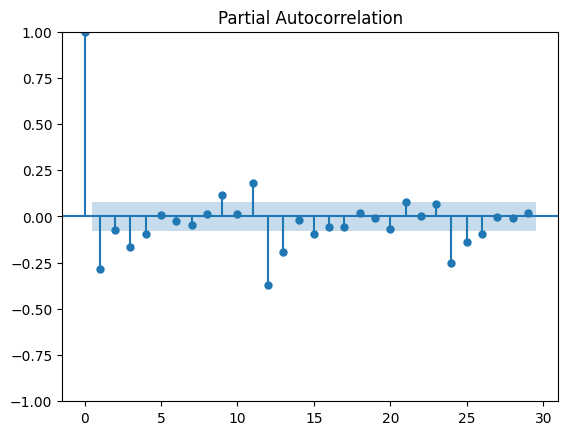

In [82]:
plot_acf(train['diff_seasonal_regular'].dropna())
plt.show()

plot_pacf(train['diff_seasonal_regular'].dropna())
plt.show()

**Osservazioni dai Grafici:**

*   **Grafico ACF della serie `diff_seasonal_regular`:**
    *   Si osserva uno **spuntone negativo significativo al lag 1**, che suggerisce un potenziale termine di Media Mobile non stagionale di ordine 1 (MA(1), q=1).
    *   Si nota anche uno **spuntone negativo significativo al lag 12**, indicativo di un potenziale termine di Media Mobile stagionale di ordine 1 (SMA(1), Q=1), con periodo stagionale s=12.
    *   Le altre autocorrelazioni tendono a decadere rapidamente o a rimanere all'interno della banda di confidenza.

*   **Grafico PACF della serie `diff_seasonal_regular`:**
    *   Si osserva uno **spuntone negativo significativo al lag 1**, che suggerisce un potenziale termine Autoregressivo non stagionale di ordine 1 (AR(1), p=1).
    *   È presente anche uno **spuntone negativo significativo al lag 12**, indicativo di un potenziale termine Autoregressivo stagionale di ordine 1 (SAR(1), P=1).
    *   La PACF tende a "tagliare" o a diventare non significativa dopo questi lag iniziali e stagionali.

**Implicazioni per la Scelta del Modello SARIMA:**
L'analisi congiunta dei grafici ACF e PACF sulla serie stazionaria `diff_seasonal_regular` suggerisce che un modello SARIMA(p,d,q)(P,D,Q)<sub>s</sub> potrebbe essere configurato come segue:
*   **Ordini Non Stagionali (p,d,q):** (1,1,1), dato che d=1 per la differenziazione non stagionale, p=1 indicato dalla PACF e q=1 indicato dall'ACF.
*   **Ordini Stagionali (P,D,Q)<sub>s</sub>:** (1,1,1)<sub>12</sub>, dato che D=1 per la differenziazione stagionale, P=1 indicato dalla PACF al lag 12, Q=1 indicato dall'ACF al lag 12, e s=12 per la periodicità mensile.

---

<br>

### Modellazione SARIMA (Seasonal ARIMA) e Previsione Finale

Sulla base dell'analisi della stazionarietà e dei pattern nei grafici ACF e PACF della serie trasformata (Box-Cox) e differenziata, è stato costruito un modello SARIMA (Seasonal Autoregressive Integrated Moving Average) per la previsione.

In [83]:
# Build ARIMA model
# order=(p,d,q) where:
# p: AR order, d: differencing, q: MA order
model = ARIMA(
    train['BoxCox_average'],  # Using the Box-Cox transformed data
    order=(1, 1, 1),              # ARIMA(1,1,1)
    seasonal_order=(1, 1, 1, 12)  # Seasonal ARIMA component (P,D,Q,s) aka SARIMA
).fit()

# Generate forecasts directly in the Box-Cox space
boxcox_forecasts = model.forecast(steps=len(test))

# Invert the Box-Cox transformation to get back to the original scale
forecasts = inv_boxcox(boxcox_forecasts, lambda0)

# Plot the forecasts
def plot_forecasts(forecasts, title):
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=train.index, y=train['average'], name='Train'))
    fig.add_trace(go.Scatter(x=test.index, y=test['average'], name='Test'))
    fig.add_trace(go.Scatter(x=test.index, y=forecasts, name='Forecast'))
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=650, title_x=0.5, height=400, xaxis_title='Date',
                      yaxis_title='Average Value')
    return fig.show()

plot_forecasts(forecasts, 'SARIMA Forecast')


mean_abs_err=(np.abs(forecasts-test['average'])/test['average']).mean()
print(f'Mean absolute error: {mean_abs_err}')

Mean absolute error: 0.0012010173721293388


**Generazione e Valutazione delle Previsioni:**

1.  Le previsioni sono state generate sulla scala Box-Cox per il periodo coperto dal set di test.
2.  Successivamente, queste previsioni sono state riconvertite alla scala originale dei dati `average` applicando la trasformazione inversa di Box-Cox.

**Risultati delle Previsioni del Modello SARIMA:**

*   **Confronto Visivo:** Il grafico dimostra un'eccellente aderenza delle previsioni del modello (linea "Forecast") ai dati reali del test set. Il modello cattura con notevole precisione sia il trend ascendente che le fluttuazioni stagionali della serie CO2.
*   **Accuratezza Quantitativa:** Il Mean Absolute Error (calcolato come errore relativo medio) tra le previsioni e i valori effettivi del test set è risultato essere circa **0.0012 (o 0.12%)**.

**Conclusioni:**  
Il modello $\text{SARIMA}(1,1,1)(1,1,1)_{12}\space\space$,  applicato alla serie trasformata con Box-Cox, ha fornito le previsioni più accurate tra i modelli testati, con un errore medio estremamente basso. Questo risultato evidenzia l'efficacia dei modelli SARIMA nel catturare complesse strutture di dipendenza temporale, inclusi trend, stagionalità e componenti autoregressive e a media mobile. La scelta degli ordini basata sull'analisi dei grafici ACF e PACF si è dimostrata valida, portando a un modello performante per la previsione dei livelli di CO2.